In [1]:
# imports
from fastai.tabular.all import *
from src.data.utils import gedi_utils
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS, SIERRAS_GEDI_ALL_COLUMNS, SEKI_GEDI_ALL_COLUMNS
from src.data.gedi import gedi_loader
from src.constants import DATA_PATH, GEDI_INTERMEDIATE_PATH, INTERMEDIATE_RESULTS
from fastai.tabular.all import load_pickle, save_pickle
from src.data.processing import severity_overlay as se
from src.data.processing import raster_overlays as ro
from src.data.adapters import calfire_perimeters as cp
from src.data.pipelines import run_overlays as overlays
from src.data.adapters import mtbs as mtbs_adapter
from src.data.pipelines import aggregate_analysis as aa
import numpy as np
from scipy import stats
import statsmodels.api as sm
from src.utils.eval import mse, rmse, r_squared, rma_regression
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")
from src.data.processing import gedi_raster_matching

from src.counterfactuals.nearby import nearby
from src.counterfactuals.rf import train
from src.counterfactuals.rf import rf

import pandas as pd

import importlib
importlib.reload(se)
importlib.reload(ro)
importlib.reload(gedi_utils)
importlib.reload(aa)
importlib.reload(nearby)
importlib.reload(train)
importlib.reload(rf)

2024-02-09 19:44:02,075 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:44:02,077 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:44:02,368 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/severity_overlay.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:44:02,369 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/raster_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:44:02,371 DEBUG: Logger /home/jk871/fire-regen/src/data/pipelines/aggregate_analysis.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-02-09 19:44:02,384 DEBUG: Logger /home/jk871/fire-regen/src/counterfactuals/nearby/ne

<module 'src.counterfactuals.rf.rf' from '/home/jk871/fire-regen/src/counterfactuals/rf/rf.py'>

In [3]:
INPUT_PATH = f"{DATA_PATH}/evaluation/placebo_sets"

In [73]:
test_landsat_simple = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat.pkl")
calibration_landsat_simple = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat.pkl")

In [17]:
def evaluate_placebo_set(outcome_variable, df_i):
    df = df_i[[outcome_variable, f"{outcome_variable}_cf"]].dropna()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    print(f"Evaluating Placebo Set 1:")
    #df = load_pickle(f"{INPUT_PATH}/matching_placebo_set_1_1.pkl").dropna()
    x_cf = df[f"{outcome_variable}_cf"].to_numpy()
    x = df[outcome_variable].to_numpy()
    outcome_diff = x_cf - x

    # Print stats
    a = rmse(x, x_cf)
    b = r_squared(x, x_cf)
    print(f"RMSE: {a}")
    print(f"R^2: {b}")
    print(f"RMA regression: {rma_regression(x, x_cf)}")

    sns.kdeplot(outcome_diff, ax=ax)
    ax.axvline(x=0)


In [4]:
test_landsat_simple = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat.pkl")
calibration_landsat_simple = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat.pkl")

# Test with all unburned (without land cover)

In [13]:
unburned = load_pickle("/maps/fire-regen/data/intermediate/pipelines/severity_aggregated_info_da_no_lc_for_unburned.pkl")

In [14]:
unburned = unburned[unburned.YSF < 0]

In [15]:
len(unburned)

4039069

(0.0, 110.0)

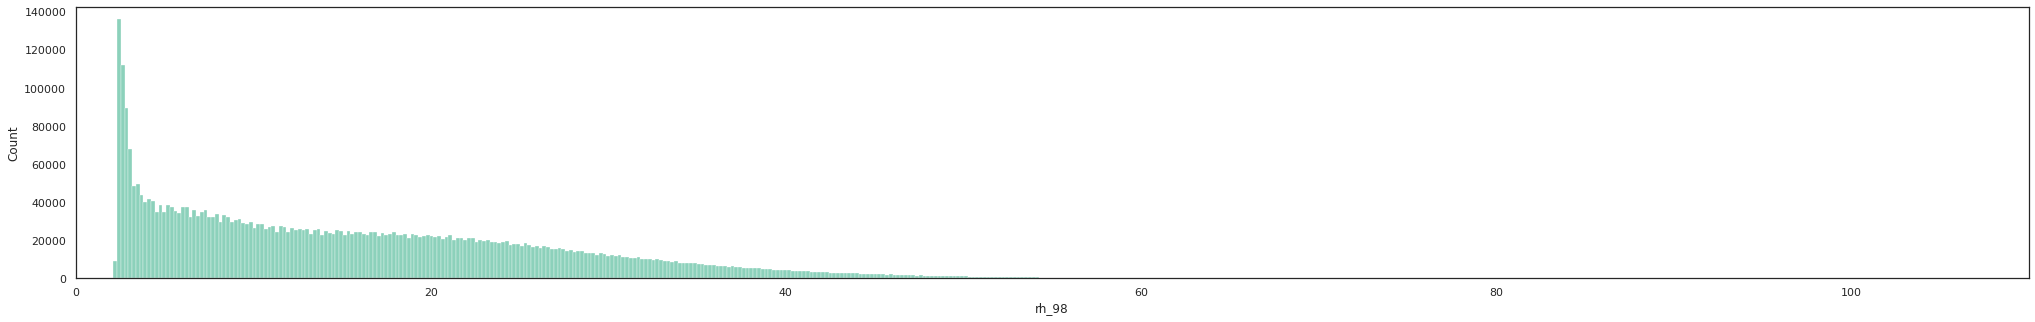

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.histplot(unburned, x="rh_98")
ax.set_xlim(0, 110)

In [ ]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat.pkl")
calibration = load_pickle(f"{INPUT_PATH}/set1/calibration_ext_aug_monthly_landsat.pkl")

In [ ]:
from src.data.processing import advanced_landsat_overlay as alo
GEDI_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98']
TERRAIN_VARIABLES = ['slope', 'elevation', 'aspect']
TS_LANDSAT = []
for month in range(1, 13):
    for band in alo.MONTHLY_BANDS:
        TS_LANDSAT.append(f"{band}_{month}")

In [ ]:
FEATURES = TERRAIN_VARIABLES + TS_LANDSAT

In [ ]:
len(calibration[calibration.rh_98 < 3])

357797

(0.0, 110.0)

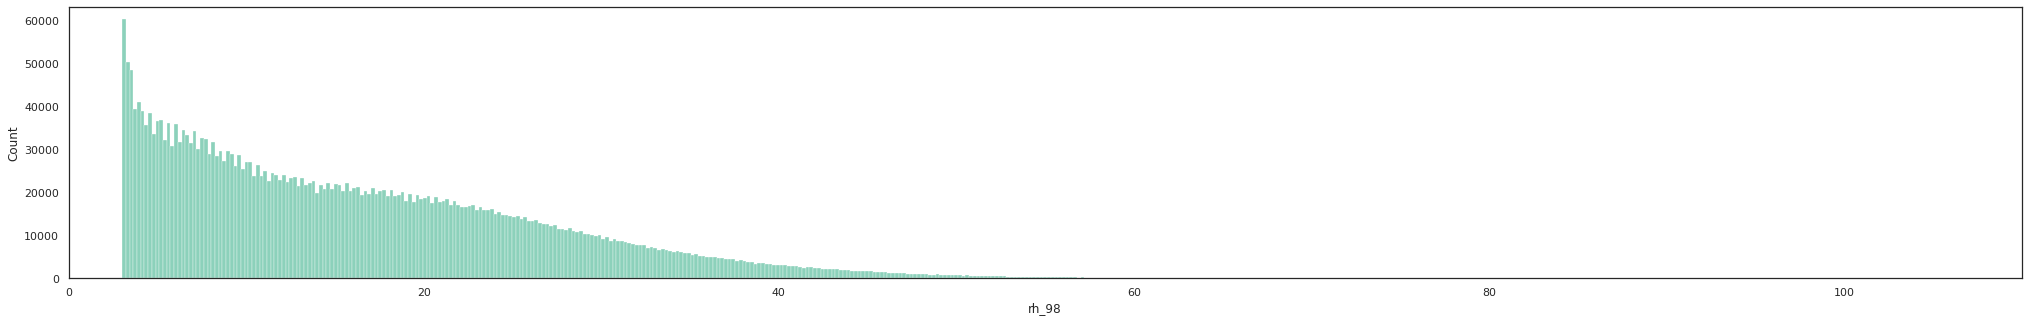

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
sns.histplot(calibration[calibration.rh_98 > 3], x="rh_98")
ax.set_xlim(0, 110)

In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration[calibration.rh_98 > 3])

2024-02-06 05:28:59,209 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

2024-02-06 05:29:13,180 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-06 05:37:54,347 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-06 05:37:59,124 INFO: Training rmse: 5.771539482983663; R^2: 0.7073536652150522 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-06 05:37:59,125 INFO: Validation error: 0.6345919249392273 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [ ]:
calibration_tall = calibration[calibration.rh_98 > 3]
to_test = train.prep_data_for_rf(calibration_tall, FEATURES, "rh_98")

2024-02-06 05:49:45,535 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [ ]:
calibration_tall["rh_98_cf"] = m.predict(to_test.train.xs)

In [ ]:
rmse(calibration.rh_98, calibration.rh_98_cf)

5.56663246332941

In [ ]:
r_squared(calibration.rh_98, calibration.rh_98_cf)

0.740622632179973

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration[calibration.rh_98 > 3], tf=test_ds)

2024-02-06 05:48:22,231 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

Evaluating Placebo Set 1:
RMSE: 7.838384793969203
R^2: 0.4802985747168427
RMA regression: (0.4668240421555384, 1.588101876795923)


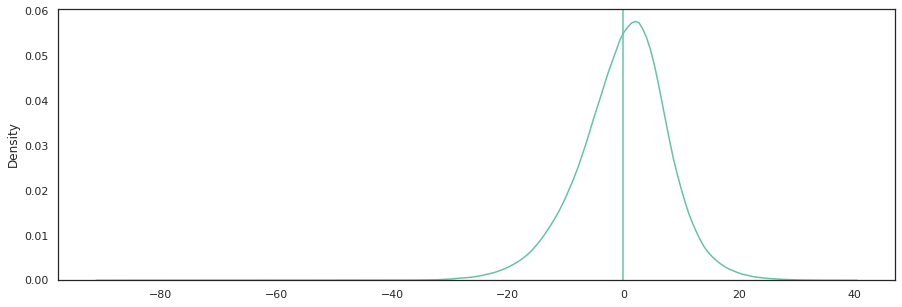

In [ ]:
evaluate_placebo_set("rh_98", test_ds)

[0.0, 100.0, 0.0, 100.0]


(0.0, 50.0)

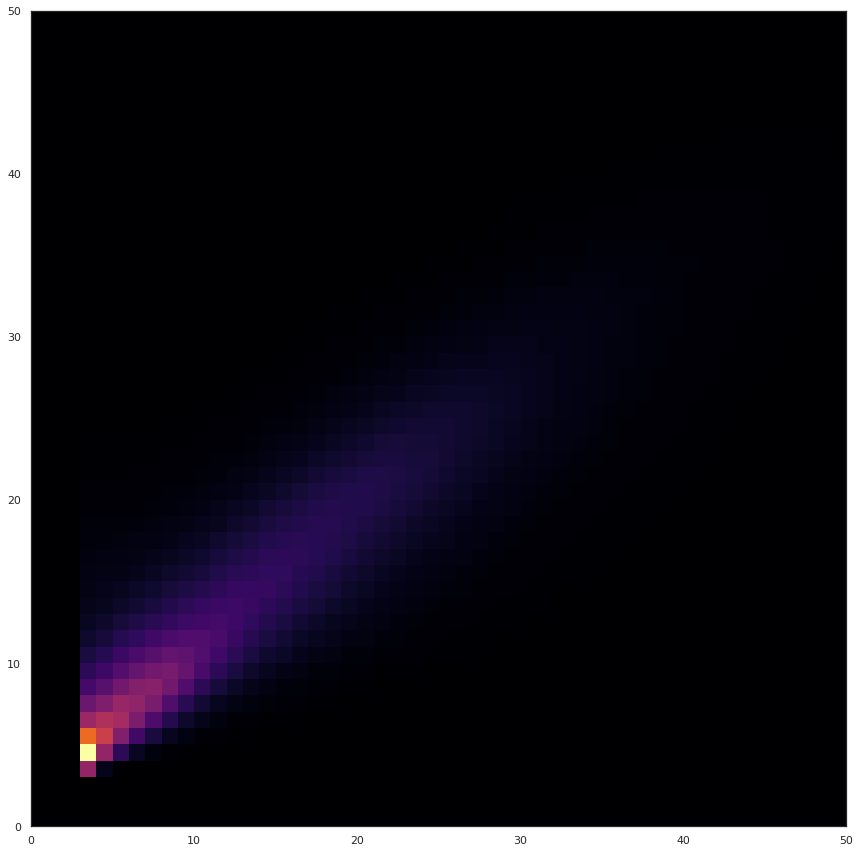

In [ ]:
heatmap, xedges, yedges = np.histogram2d(calibration_tall.rh_98, calibration_tall.rh_98_cf, bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=plt.cm.inferno)
fig.set_facecolor("white")
plt.gcf().set_facecolor("white")
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))

# Monthly Landsat with Tree Canopy Cover

In [5]:
year = 2019
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat_{year}.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat_{year}.pkl")

In [6]:
test_ds["NDVI_2020"] = test_landsat_simple.NDVI_2020
calibration_ds["NDVI_2020"] = calibration_landsat_simple.NDVI_2020

In [7]:
trainer = rf.MonthlyLandsatRF(2019, additional_features=["tcc_2000", "tcc_2005", "tcc_2010", "tcc_2015"])

In [8]:
m, to = trainer.train("NDVI_2020", calibration_ds, test_ds)

2024-02-08 22:23:08,119 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B6_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B6_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B6_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B6_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B6_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B6_1

In [9]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 22:29:04,511 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B6_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B6_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B6_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B6_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B6_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B6_1

# Monthly on extended unburned dataset

In [3]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat_2019.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat_2019.pkl")

<AxesSubplot: xlabel='tcc_2015', ylabel='Count'>

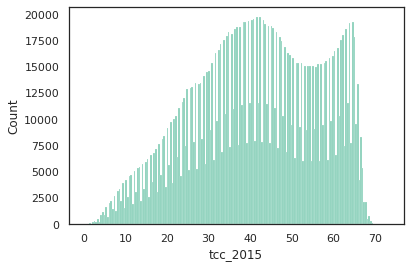

In [47]:
sns.histplot(calibration_ds, x="tcc_2015")

In [42]:
calibration_ds = calibration_ds[calibration_ds.tcc_2015 > 30]

In [33]:
len(calibration_ds)

3021703

In [4]:
trainer = rf.MonthlyLandsatRF(2019, additional_features=["tcc_2000", "tcc_2005", "tcc_2010", "tcc_2015"])

In [49]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 23:48:57,359 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B6_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B6_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B6_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B6_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B6_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B6_1

In [11]:
m, to = trainer.train("rh_98", calibration_ds, test_ds, log=True)

2024-02-09 00:13:02,522 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B6_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B6_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B6_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B6_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B6_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B6_1

# Monthly Landsat

In [108]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat.pkl")

In [109]:
test_ds["NDVI_2020"] = test_landsat_simple.NDVI_2020
calibration_ds["NDVI_2020"] = calibration_landsat_simple.NDVI_2020

In [110]:
trainer = rf.MonthlyLandsatRF(2019)

In [76]:
m, to = trainer.train("NDVI_2020", calibration_ds, test_ds)

2024-02-08 04:00:19,898 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B6_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B6_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B6_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B6_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B6_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B6_1

In [111]:
m_2019, to_2019 = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 05:21:50,267 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B6_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B6_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B6_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B6_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B6_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B6_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B6_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B6_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B6_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B6_1

[0.0, 100.0, 0.0, 100.0]


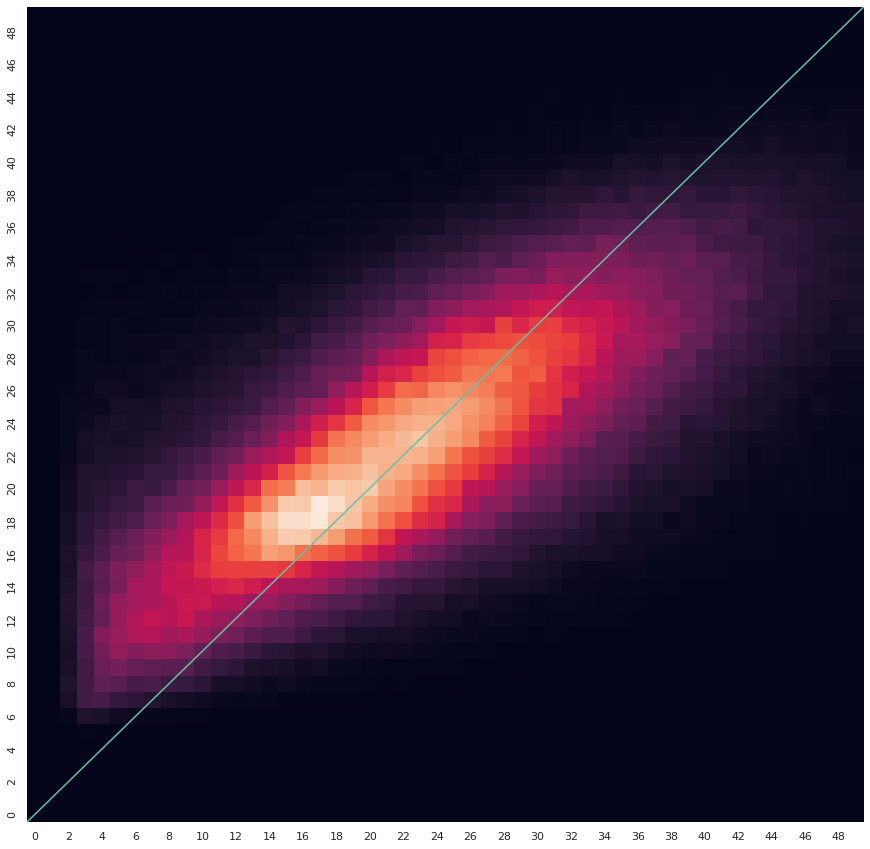

In [113]:
heatmap, xedges, yedges = np.histogram2d(to_2019.valid.y, m_2019.predict(to_2019.valid.xs), bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(heatmap.T, cbar=False)
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))
abline(1, 0, ax)

In [114]:
fi = rf.rf_feat_importance(m_2019, to_2019.train.xs)
fi[:20]

,cols,imp
157,SR_B6_8,0.231220
166,SR_B7_9,0.090441
154,SR_B3_8,0.073717
163,SR_B4_9,0.045112
150,SR_B7_7,0.035680
147,SR_B4_7,0.025786
155,SR_B4_8,0.024143
194,aspect,0.022426
158,SR_B7_8,0.018775
120,SR_B1_4,0.018245


# Predict Canopy Cover

### From Monthly data

In [4]:
year = 2003
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat_{year}.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat_{year}.pkl")

In [5]:
trainer = rf.MonthlyLandsatRF(2003)

In [6]:
m, to = trainer.train("tcc_2005", calibration_ds, test_ds)

2024-02-09 19:46:03,561 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B7_11', 'NDVI_11', 'SR_B1_12', 'SR_B2_12', 'SR_B3_12', 'SR_B4_12', 'SR_B5_12', 'SR_B7_12', 'NDVI_12', 'slope', 'ele

### From 5 years of data

In [7]:
year = 2003
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat_{year}_5.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat_{year}_5.pkl")

In [8]:
trainer = rf.LandsatTimeSeriesRF(years = list(range(year - 4, year + 1)))

In [9]:
m, to = trainer.train("tcc_2005", calibration_ds, test_ds)

2024-02-09 19:55:05,008 INFO: Training with features ['SR_B1_1999', 'SR_B2_1999', 'SR_B3_1999', 'SR_B4_1999', 'SR_B5_1999', 'SR_B7_1999', 'NDVI_1999', 'SR_B1_2000', 'SR_B2_2000', 'SR_B3_2000', 'SR_B4_2000', 'SR_B5_2000', 'SR_B7_2000', 'NDVI_2000', 'SR_B1_2001', 'SR_B2_2001', 'SR_B3_2001', 'SR_B4_2001', 'SR_B5_2001', 'SR_B7_2001', 'NDVI_2001', 'SR_B1_2002', 'SR_B2_2002', 'SR_B3_2002', 'SR_B4_2002', 'SR_B5_2002', 'SR_B7_2002', 'NDVI_2002', 'SR_B1_2003', 'SR_B2_2003', 'SR_B3_2003', 'SR_B4_2003', 'SR_B5_2003', 'SR_B7_2003', 'NDVI_2003', 'slope', 'elevation', 'aspect', 'SR_B1_mean', 'SR_B1_std', 'SR_B2_mean', 'SR_B2_std', 'SR_B3_mean', 'SR_B3_std', 'SR_B4_mean', 'SR_B4_std', 'SR_B5_mean', 'SR_B5_std', 'SR_B7_mean', 'SR_B7_std', 'NDVI_mean', 'NDVI_std']. [in train at /home/jk871/fire-regen/src/counterfactuals/rf/rf.py:117]
1672243 430999
2103242
2024-02-09 19:55:07,242 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:86]
2024-02-09 19:55:1

# Monthly from 2003 + canopy cover

In [10]:
year = 2003
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat_{year}.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat_{year}.pkl")

In [11]:
trainer = rf.MonthlyLandsatRF(2003, additional_features=["tcc_2000"])

In [12]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 22:37:20,053 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_6', 'SR_B2_6', 'SR_B3_6', 'SR_B4_6', 'SR_B5_6', 'SR_B7_6', 'NDVI_6', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B7_11', 'NDVI_11', 'SR_B1_12', 'SR_B2_12', 'SR_B3_12', 'SR_B4_12', 'SR_B5_12', 'SR_B7_12', 'NDVI_12', 'slope', 'ele

### Train on Monthly from 2003

In [115]:
year = 2003

In [116]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_monthly_landsat_{year}.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_monthly_landsat_{year}.pkl")

In [117]:
trainer = rf.MonthlyLandsatRF(2003)

In [118]:
m_2003, to_2003 = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 05:37:47,469 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B7_11', 'NDVI_11', 'SR_B1_12', 'SR_B2_12', 'SR_B3_12', 'SR_B4_12', 'SR_B5_12', 'SR_B7_12', 'NDVI_12', 'slope', 'elevation', 'aspect']. [in train at /home/jk871/fire-regen/src/counterfactuals/

In [122]:
m_2003, to_2003 = trainer.train("agbd", calibration_ds, test_ds, log=True)

2024-02-08 05:43:59,042 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B7_11', 'NDVI_11', 'SR_B1_12', 'SR_B2_12', 'SR_B3_12', 'SR_B4_12', 'SR_B5_12', 'SR_B7_12', 'NDVI_12', 'slope', 'elevation', 'aspect']. [in train at /home/jk871/fire-regen/src/counterfactuals/

[0.0, 100.0, 0.0, 100.0]


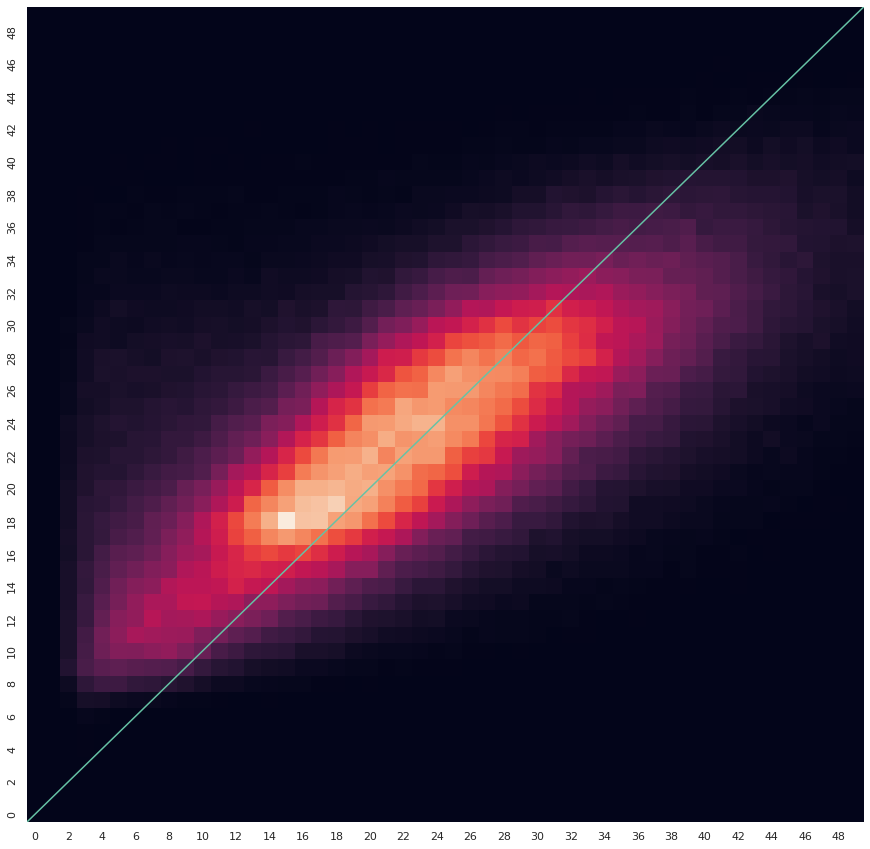

In [120]:
heatmap, xedges, yedges = np.histogram2d(to_2003.valid.y, m_2003.predict(to_2003.valid.xs), bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(heatmap.T, cbar=False)
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))
abline(1, 0, ax)

In [121]:
fi = rf.rf_feat_importance(m_2003, to_2003.train.xs)
fi[:20]

,cols,imp
123,SR_B5_8,0.159146
124,SR_B7_8,0.146356
109,SR_B5_5,0.059796
121,SR_B3_8,0.058481
128,SR_B3_9,0.054781
139,NDVI_10,0.045201
156,aspect,0.025986
126,SR_B1_9,0.022700
106,SR_B2_5,0.022160
127,SR_B2_9,0.020599


In [84]:
trainer = rf.MonthlyLandsatRF(2003)

In [85]:
m, to = trainer.train("rh_98", calibration_ds, test_ds, augment=True)

2024-02-08 04:36:14,950 INFO: Training with features ['SR_B1_1', 'SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B7_1', 'NDVI_1', 'SR_B1_2', 'SR_B2_2', 'SR_B3_2', 'SR_B4_2', 'SR_B5_2', 'SR_B7_2', 'NDVI_2', 'SR_B1_3', 'SR_B2_3', 'SR_B3_3', 'SR_B4_3', 'SR_B5_3', 'SR_B7_3', 'NDVI_3', 'SR_B1_4', 'SR_B2_4', 'SR_B3_4', 'SR_B4_4', 'SR_B5_4', 'SR_B7_4', 'NDVI_4', 'SR_B1_5', 'SR_B2_5', 'SR_B3_5', 'SR_B4_5', 'SR_B5_5', 'SR_B7_5', 'NDVI_5', 'SR_B1_7', 'SR_B2_7', 'SR_B3_7', 'SR_B4_7', 'SR_B5_7', 'SR_B7_7', 'NDVI_7', 'SR_B1_8', 'SR_B2_8', 'SR_B3_8', 'SR_B4_8', 'SR_B5_8', 'SR_B7_8', 'NDVI_8', 'SR_B1_9', 'SR_B2_9', 'SR_B3_9', 'SR_B4_9', 'SR_B5_9', 'SR_B7_9', 'NDVI_9', 'SR_B1_10', 'SR_B2_10', 'SR_B3_10', 'SR_B4_10', 'SR_B5_10', 'SR_B7_10', 'NDVI_10', 'SR_B1_11', 'SR_B2_11', 'SR_B3_11', 'SR_B4_11', 'SR_B5_11', 'SR_B7_11', 'NDVI_11', 'SR_B1_12', 'SR_B2_12', 'SR_B3_12', 'SR_B4_12', 'SR_B5_12', 'SR_B7_12', 'NDVI_12', 'slope', 'elevation', 'aspect', 'SR_B1_mean', 'SR_B1_max', 'SR_B1_min', 'SR_B1_coeff_v', 

# Advanced Landsat

In [ ]:
test_landsat_simple = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat.pkl")
calibration_landsat_simple = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat.pkl")

In [ ]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_advanced_landsat.pkl")
test_ds["NDVI_2020"] = test_landsat_simple.NDVI_2020
test_ds["NDVI_leaf_on_mean"] = test_landsat_simple.NDVI_2019

In [ ]:
calibration = load_pickle(f"{INPUT_PATH}/set1/calibration_aug__advanced_landsat.pkl")
calibration["NDVI_leaf_on_mean"] = calibration_landsat_simple.NDVI_2019
calibration["NDVI_2020"] = calibration_landsat_simple.NDVI_2020

In [ ]:
from src.data.processing import advanced_landsat_overlay as alo
GEDI_VARIABLES = ['agbd', 'cover', 'fhd_normal', 'pai', 'rh_25', 'rh_50', 'rh_70', 'rh_98']
TERRAIN_VARIABLES = ['slope', 'elevation', 'aspect']
TS_LANDSAT = ["NDVI_leaf_on_mean"]
for kind in ["mean", "min", "max", "stddev", "qt_25", "qt_50", "qt_75"]:
    for band in alo.BANDS:
        TS_LANDSAT.append(f"{band}_{kind}")

In [ ]:
AUG_VARS = []
for band in alo.BANDS:
    new_col = f"{band}_max_min"
    calibration[new_col] = calibration[f"{band}_max"] - calibration[f"{band}_min"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_50_qt_25"
    calibration[new_col] = calibration[f"{band}_qt_50"] - calibration[f"{band}_qt_25"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_75_qt_25"
    calibration[new_col] = calibration[f"{band}_qt_75"] - calibration[f"{band}_qt_25"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_75_qt_50"
    calibration[new_col] = calibration[f"{band}_qt_75"] - calibration[f"{band}_qt_50"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_max_median"
    calibration[new_col] = calibration[f"{band}_max"] - calibration[f"{band}_qt_50"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_max_qt_75"
    calibration[new_col] = calibration[f"{band}_max"] - calibration[f"{band}_qt_75"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_median_min"
    calibration[new_col] = calibration[f"{band}_qt_50"] - calibration[f"{band}_min"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_25_min"
    calibration[new_col] = calibration[f"{band}_qt_25"] - calibration[f"{band}_min"]
    AUG_VARS.append(new_col)
    

'\n    new_col = f"{band}_max_median"\n    calibration[new_col] = calibration[f"{band}_max"] - calibration[f"{band}_qt_50"]\n    AUG_VARS.append(new_col)\n\n    new_col = f"{band}_max_qt_75"\n    calibration[new_col] = calibration[f"{band}_max"] - calibration[f"{band}_qt_75"]\n    AUG_VARS.append(new_col)\n\n    new_col = f"{band}_median_min"\n    calibration[new_col] = calibration[f"{band}_qt_50"] - calibration[f"{band}_min"]\n    AUG_VARS.append(new_col)\n\n    new_col = f"{band}_qt_25_min"\n    calibration[new_col] = calibration[f"{band}_qt_25"] - calibration[f"{band}_min"]\n    AUG_VARS.append(new_col)\n    '

In [ ]:
AUG_VARS = []
for band in alo.BANDS:
    new_col = f"{band}_max_min"
    test_ds[new_col] = test_ds[f"{band}_max"] - test_ds[f"{band}_min"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_50_qt_25"
    test_ds[new_col] = test_ds[f"{band}_qt_50"] - test_ds[f"{band}_qt_25"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_75_qt_25"
    test_ds[new_col] = test_ds[f"{band}_qt_75"] - test_ds[f"{band}_qt_25"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_75_qt_50"
    test_ds[new_col] = test_ds[f"{band}_qt_75"] - test_ds[f"{band}_qt_50"]
    AUG_VARS.append(new_col)
'''
    new_col = f"{band}_max_median"
    test_ds[new_col] = test_ds[f"{band}_max"] - test_ds[f"{band}_qt_50"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_max_qt_75"
    test_ds[new_col] = test_ds[f"{band}_max"] - test_ds[f"{band}_qt_75"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_median_min"
    test_ds[new_col] = test_ds[f"{band}_qt_50"] - test_ds[f"{band}_min"]
    AUG_VARS.append(new_col)

    new_col = f"{band}_qt_25_min"
    test_ds[new_col] = test_ds[f"{band}_qt_25"] - test_ds[f"{band}_min"]
    AUG_VARS.append(new_col)
    '''

'\n    new_col = f"{band}_max_median"\n    test_ds[new_col] = test_ds[f"{band}_max"] - test_ds[f"{band}_qt_50"]\n    AUG_VARS.append(new_col)\n\n    new_col = f"{band}_max_qt_75"\n    test_ds[new_col] = test_ds[f"{band}_max"] - test_ds[f"{band}_qt_75"]\n    AUG_VARS.append(new_col)\n\n    new_col = f"{band}_median_min"\n    test_ds[new_col] = test_ds[f"{band}_qt_50"] - test_ds[f"{band}_min"]\n    AUG_VARS.append(new_col)\n\n    new_col = f"{band}_qt_25_min"\n    test_ds[new_col] = test_ds[f"{band}_qt_25"] - test_ds[f"{band}_min"]\n    AUG_VARS.append(new_col)\n    '

In [ ]:
FEATURES = TERRAIN_VARIABLES + TS_LANDSAT + AUG_VARS#+  ["gridded_pft_class"]

In [ ]:
calibration_no_na = calibration.dropna()
test_ds_no_na = test_ds.dropna()

In [ ]:
# 500 estimators
# min sample leaf = 20
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

2024-02-04 09:12:12,801 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
2024-02-04 09:12:17,349 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 09:29:59,062 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 09:30:06,181 INFO: Training rmse: 6.130150919539324; R^2: 0.6577773913404739 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 09:30:06,183 INFO: Validation error: 0.5080824367532909 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


2024-02-04 09:30:55,551 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
Evaluating Placebo Set 1:
RMSE: 7.797275880207327
R^2: 0.4805984840877442
RMA regression: (0.463504391142404, 1.750862638264648)


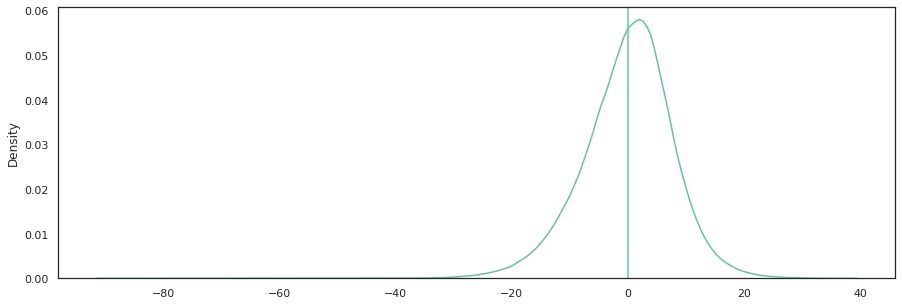

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
# min sample leaf = 5
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

2024-02-04 08:55:49,556 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
2024-02-04 08:56:31,271 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 09:07:00,040 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 09:07:04,151 INFO: Training rmse: 4.328067093150478; R^2: 0.8294096998857396 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 09:07:04,153 INFO: Validation error: 0.5097403483332289 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


2024-02-04 09:07:54,356 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
Evaluating Placebo Set 1:
RMSE: 7.800062462874438
R^2: 0.48022717135982707
RMA regression: (0.46437570936748973, 1.7362421256609117)


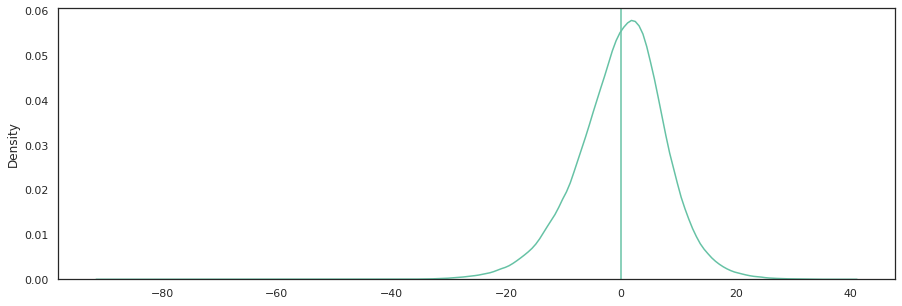

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
# Best so far -2
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_rh98_advanced_landsat_double_augmented_leaf_5.pkl", m)
to.export(f"{DATA_PATH}/evaluation/rf/models/to_rh98_advanced_landsat_double_augmented_leaf_5.pkl")

In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

2024-02-04 08:38:40,884 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
2024-02-04 08:38:56,560 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 08:46:19,258 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 08:46:21,493 INFO: Training rmse: 6.468420123340555; R^2: 0.6189668129825111 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 08:46:21,494 INFO: Validation error: 0.5024303367687233 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [ ]:
# Best so far -2
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_rh98_advanced_landsat_double_augmented.pkl", m)
to.export(f"{DATA_PATH}/evaluation/rf/models/to_rh98_advanced_landsat_double_augmented.pkl")

2024-02-04 08:47:20,549 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Evaluating Placebo Set 1:
RMSE: 7.823287821998173
R^2: 0.4771272261367502
RMA regression: (0.459322646596258, 1.8999650872174225)


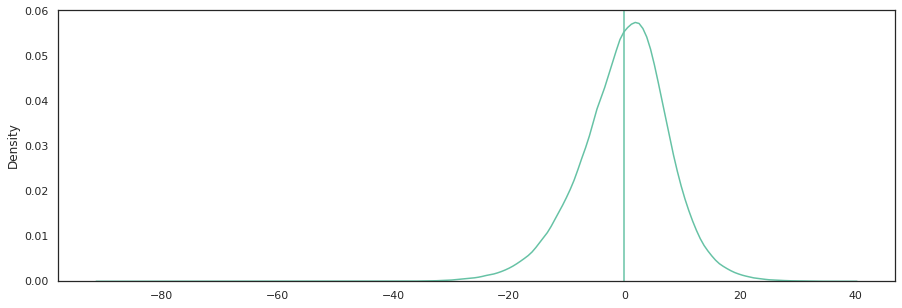

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
fi = rf_feat_importance(m, to.train.xs)
fi[:10]

,cols,imp
106,SR_B7_qt_75,0.186757
105,SR_B6_qt_75,0.105846
86,SR_B3_qt_50,0.067157
10,SR_B7_mean,0.052978
87,SR_B4_qt_50,0.049170
13,NBR_mean,0.037172
103,SR_B4_qt_75,0.024692
2,aspect,0.019319
90,SR_B7_qt_50,0.017552
71,SR_B4_qt_25,0.016653


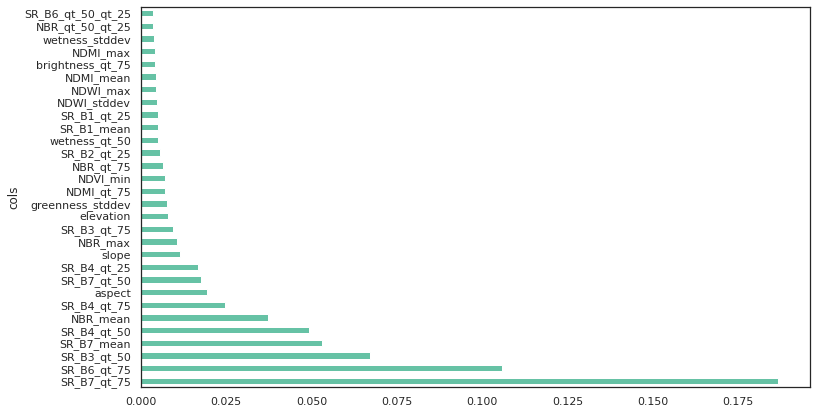

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
m, to = train_for_var("rh_70", FEATURES, df=calibration_no_na)

2024-02-04 08:28:49,469 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
2024-02-04 08:28:52,774 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 08:34:35,225 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 08:34:37,650 INFO: Training rmse: 5.145467702989766; R^2: 0.6302565301920858 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 08:34:37,651 INFO: Validation error: 0.5225922378278919 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


2024-02-04 08:35:05,456 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
Evaluating Placebo Set 1:
RMSE: 6.412415046781605
R^2: 0.4964988957623486
RMA regression: (0.4861142934648882, 0.33845843355925975)


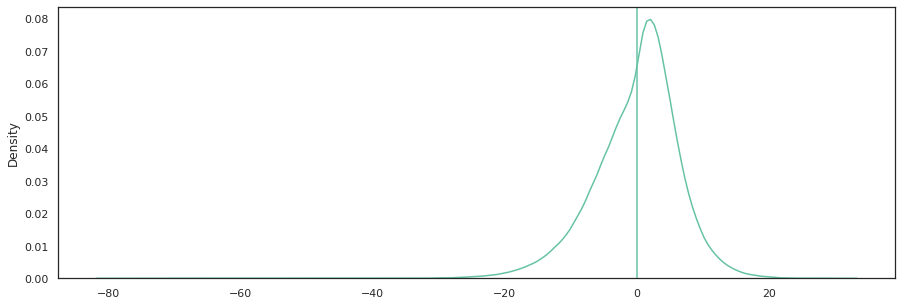

In [ ]:
get_cf("rh_70", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_70", test_ds_no_na)

In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

2024-02-04 08:20:00,328 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
2024-02-04 08:20:06,736 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 08:25:48,485 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 08:25:50,803 INFO: Training rmse: 6.511231298541489; R^2: 0.6139063932186928 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 08:25:50,804 INFO: Validation error: 0.5010847421304083 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


2024-02-04 08:26:31,327 INFO: PREP PREP PREP [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:51]
Evaluating Placebo Set 1:
RMSE: 7.841250043849296
R^2: 0.4747234442700613
RMA regression: (0.4575786845420703, 1.772059766919579)


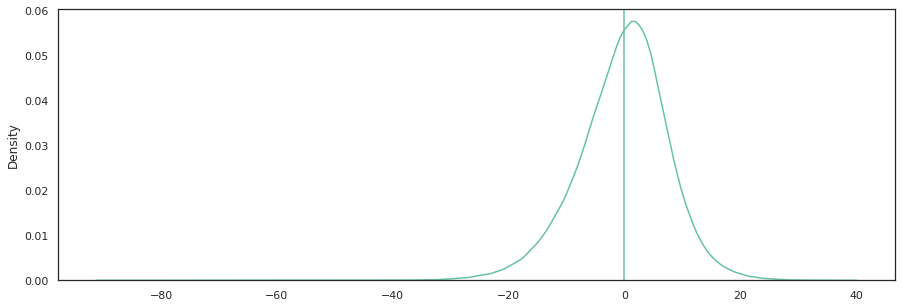

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

2024-02-04 08:01:03,151 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 08:06:44,730 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 08:06:47,076 INFO: Training rmse: 6.512654320106609; R^2: 0.6137376142148789 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 08:06:47,077 INFO: Validation error: 0.5009683726438119 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [ ]:
# Best so far
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_rh98_advanced_landsat_augmented.pkl", m)
to.export(f"{DATA_PATH}/evaluation/rf/models/to_rh98_advanced_landsat_augmented.pkl")

In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na, log=True)

2024-02-04 08:10:45,805 DEBUG: Optimizing for log [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:23]
2024-02-04 08:10:50,528 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 08:16:54,841 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 08:16:57,101 INFO: Training rmse: 0.35071796161847; R^2: 0.5997536087872758 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 08:16:57,102 INFO: Validation error: 0.4855964316680522 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


Evaluating Placebo Set 1:
RMSE: 8.020532295041404
R^2: 0.45042901535399704
RMA regression: (0.46746486621843236, -0.04585277154678913)


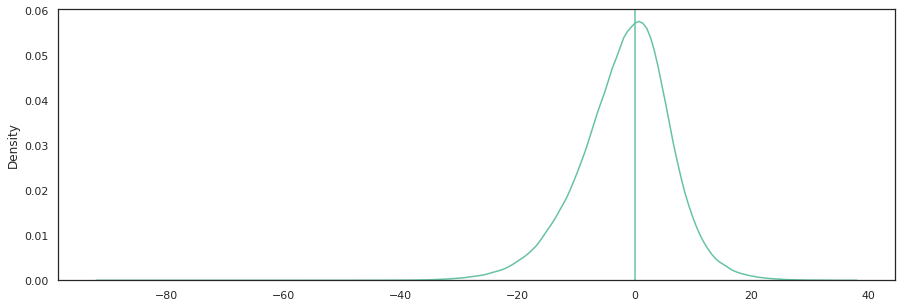

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na, log=True)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_rh98_advanced_landsat_augmented_log.pkl", m)
to.export(f"{DATA_PATH}/evaluation/rf/models/to_rh98_advanced_landsat_augmented_log.pkl")

Evaluating Placebo Set 1:
RMSE: 7.822651528880028
R^2: 0.4772122765210517
RMA regression: (0.46137365406466363, 1.8362519288990384)


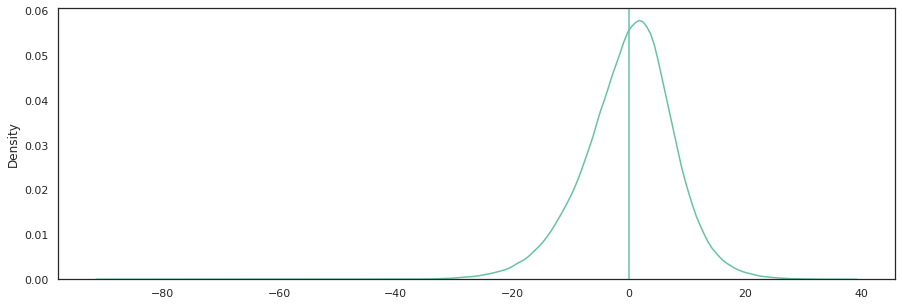

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
calibration[np.isinf(calibration.NBR_qt_25)]

,geometry,agbd,cover,fhd_normal,pai,rh_25,rh_50,rh_70,rh_98,gridded_pft_class,...,NDWI_qt_75,NBR_qt_75,NDMI_qt_75,SWIRS_qt_75,SVVI_qt_75,brightness_qt_75,greenness_qt_75,wetness_qt_75,NDVI_leaf_on_mean,NDVI_2020
shot_number,,,,,,,,,,,,,,,,,,,,,
135940500200080654,POINT (-119.06421 37.21426),249.816879,0.458487,3.283604,1.22681,-0.03,2.84,19.25,31.200001,1,...,-0.396924,0.773216,0.798612,0.227114,0.0,0.27079,0.06867,0.059845,0.522819,0.47904


In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

In [ ]:
calibration = calibration.drop(135940500200080654)

In [ ]:
np.any(np.isinf(calibration["NDVI_max"]))

False

In [ ]:
for col in FEATURES:
    if np.any(np.isinf(calibration[col])):
        print(col)

In [ ]:
qt_25_columns = [f"{band}_qt_25" for band in alo.BANDS]

In [ ]:
all_max_rows = []
for col in qt_25_columns:
    all_max_rows.append(calibration[calibration[col] > 1000000])
    all_max_rows.append(calibration[calibration[col] < -1000000])
all_extreme_rows = pd.concat(all_max_rows)

In [ ]:
calibration = calibration.drop(all_extreme_rows.index)

In [ ]:
calibration[calibration.SR_B1_qt_25 > 10000000]

,geometry,agbd,cover,fhd_normal,pai,rh_25,rh_50,rh_70,rh_98,gridded_pft_class,...,NDWI_qt_75,NBR_qt_75,NDMI_qt_75,SWIRS_qt_75,SVVI_qt_75,brightness_qt_75,greenness_qt_75,wetness_qt_75,NDVI_leaf_on_mean,NDVI_2020
shot_number,,,,,,,,,,,,,,,,,,,,,


In [ ]:
calibration.sort_values(by="SR_B1_qt_25", ascending=False).SR_B1_qt_25

shot_number
228681100200120029    0.649609
153670600300529381    0.643879
61060500200118832     0.587638
236810800300288280    0.566872
20760300200229152     0.480419
                        ...   
108340100200122067         NaN
105290200200082535         NaN
56180100200141949          NaN
201370500200078831         NaN
217891100300283039         NaN
Name: SR_B1_qt_25, Length: 1671273, dtype: float64

In [ ]:
calibration.dropna()

,geometry,agbd,cover,fhd_normal,pai,rh_25,rh_50,rh_70,rh_98,gridded_pft_class,...,NDWI_qt_75,NBR_qt_75,NDMI_qt_75,SWIRS_qt_75,SVVI_qt_75,brightness_qt_75,greenness_qt_75,wetness_qt_75,NDVI_leaf_on_mean,NDVI_2020
shot_number,,,,,,,,,,,,,,,,,,,,,
49811100300246815,POINT (-120.79104 41.34600),88.746674,0.293670,2.935234,0.695643,-0.89,2.69,7.58,19.549999,1,...,-0.631576,0.689060,0.488996,0.299362,0.0,0.222763,0.104535,0.015781,0.666703,0.673894
119970600300518496,POINT (-120.79438 41.34582),40.457424,0.232379,2.706680,0.528927,-1.12,0.56,2.54,13.260000,1,...,-0.604011,0.606285,0.368737,0.291346,0.0,0.242475,0.107999,0.002101,0.640297,0.617801
119970600300518497,POINT (-120.79383 41.34552),36.804237,0.238282,2.452687,0.544367,-1.08,0.59,2.62,11.200000,1,...,-0.609397,0.608298,0.378974,0.290731,0.0,0.239661,0.114273,0.003586,0.651192,0.630241
119970600300518498,POINT (-120.79328 41.34521),34.897552,0.209621,2.545897,0.470491,-1.08,0.52,2.17,11.380000,1,...,-0.600497,0.574856,0.341943,0.284125,0.0,0.251196,0.105652,-0.002649,0.625229,0.608310
119970600300518499,POINT (-120.79273 41.34491),38.231438,0.199425,2.578357,0.444855,-1.01,0.59,2.43,12.430000,1,...,-0.577432,0.522819,0.288362,0.265175,0.0,0.276858,0.098479,-0.010425,0.583765,0.565948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229750100200077573,POINT (-120.93387 38.77223),50.674717,0.380660,2.533050,0.958360,-0.33,1.90,4.64,12.540000,1,...,-0.611735,0.458594,0.182585,0.311243,0.0,0.314675,0.126407,-0.042539,0.589830,0.524158
52060800200082421,POINT (-120.94456 38.77246),157.037216,0.940653,2.876376,5.662046,8.12,11.45,14.19,22.540001,1,...,-0.566868,0.375195,0.130888,0.270185,0.0,0.371870,0.117178,-0.065016,0.510828,0.467573
233870800200082578,POINT (-120.93630 38.77354),87.813187,0.310199,3.084839,0.742773,-0.63,2.32,5.91,23.700001,1,...,-0.617674,0.486440,0.222116,0.318730,0.0,0.310383,0.130833,-0.037408,0.595982,0.544236


In [ ]:
len(test_ds), len(test_ds.dropna())

(430999, 395478)

In [ ]:
calibration_no_na = calibration.dropna()

In [ ]:
for col in FEATURES:
    print(col)
    print(calibration[col].max())

slope
29.999863
elevation
3527.0
aspect
358.00635
NDVI_leaf_on_mean
0.9237126022890195
SR_B1_mean
0.74104828125
SR_B2_mean
0.7467190104166668
SR_B3_mean
0.7212534375000001
SR_B4_mean
0.71426671875
SR_B5_mean
0.7388884078839869
SR_B6_mean
0.36233125
SR_B7_mean
0.299379375
NDVI_mean
0.9193157320121369
NDWI_mean
0.423341432899146
NBR_mean
0.8930303035703209
NDMI_mean
0.92224233683894
SWIRS_mean
0.46345429468054833
SVVI_mean
0.0
brightness_mean
1.2586131897947639
greenness_mean
0.28550870681250007
wetness_mean
0.6098376590885417
SR_B1_min
0.42996312500000006
SR_B2_min
0.42780437500000007
SR_B3_min
0.45002437500000003
SR_B4_min
0.423115625
SR_B5_min
0.5999475000000001
SR_B6_min
0.297069375
SR_B7_min
0.2197325
NDVI_min
0.8688860580527777
NDWI_min
0.037641178467264086
NBR_min
0.8363191739057114
NDMI_min
0.860936540232633
SWIRS_min
0.4240686380517053
SVVI_min
0.0
brightness_min
0.8330049350625001
greenness_min
0.250245711875
wetness_min
0.43620583975
SR_B1_max
1.5999850000000002
SR_B2_max
1.59

In [ ]:
# Without qt_25 columns.
m = train_for_var("NDVI_2020", FEATURES, df=calibration)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

2024-02-04 05:34:59,548 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 05:49:53,885 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 05:49:56,317 INFO: Training rmse: 0.020653536489410547; R^2: 0.975717585128458 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 05:49:56,319 INFO: Validation error: 0.9704362888343582 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [ ]:
m, to = m

In [ ]:
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_ndvi_2020_advanced_landsat_no_qt_25.pkl", m)

In [ ]:
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_ndvi_2020_advanced_landsat_no_qt_25.pkl", m)
to.export(f"{DATA_PATH}/evaluation/rf/models/to_ndvi_2020_advanced_landsat_no_qt_25.pkl")

In [ ]:
from fastai.tabular.all import *
@patch
def export(self: TabularPandas, fname='export.pkl', pickle_protocol=2):
    "Export the contents of `self` without the items"
    old_to = self
    self = self.new_empty()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pickle.dump(self, open(Path(fname), 'wb'), protocol=pickle_protocol)
        self = old_to

In [ ]:
get_cf("NDVI_2020", m, FEATURES, df=calibration, tf=test_ds)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

Evaluating Placebo Set 1:
RMSE: 0.02713397014371102
R^2: 0.9484143961298991
RMA regression: (0.9345177468498741, -0.6136692713901867)


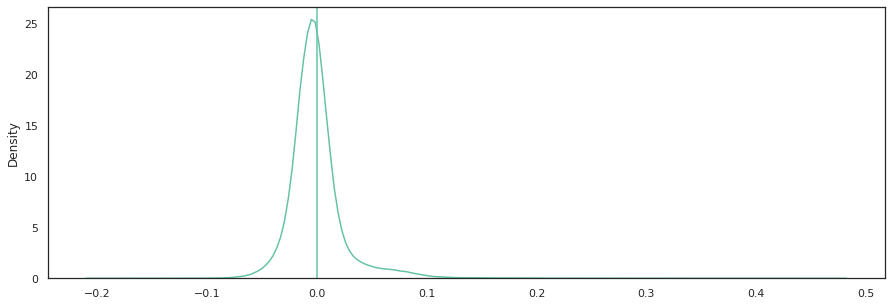

In [ ]:
evaluate_placebo_set("NDVI_2020", test_ds)

### RH 98

In [ ]:
m, to = train_for_var("rh_98", FEATURES, df=calibration_no_na)

2024-02-04 07:22:43,195 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 07:26:34,854 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 07:26:36,874 INFO: Training rmse: 6.593801457649233; R^2: 0.6040520519939445 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 07:26:36,875 INFO: Validation error: 0.49807765902841394 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


Evaluating Placebo Set 1:
RMSE: 7.8335616835197825
R^2: 0.4757530085677327
RMA regression: (0.4597636045784851, 1.9608389325774684)


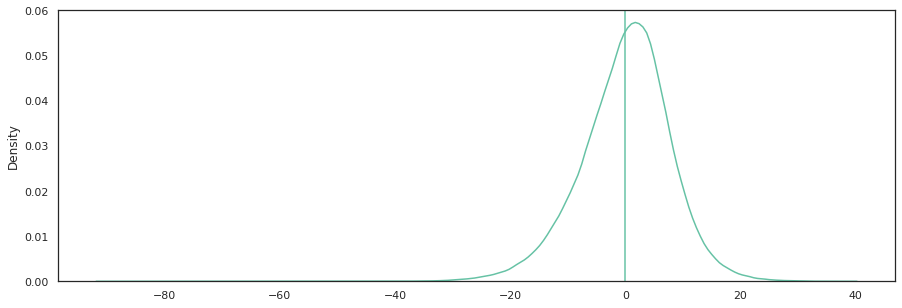

In [ ]:
test_ds_no_na = test_ds.dropna()
get_cf("rh_98", m, FEATURES, df=calibration_no_na, tf=test_ds_no_na)
evaluate_placebo_set("rh_98", test_ds_no_na)

In [ ]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    sns.lineplot(x=x_vals, y=y_vals, ax=ax)

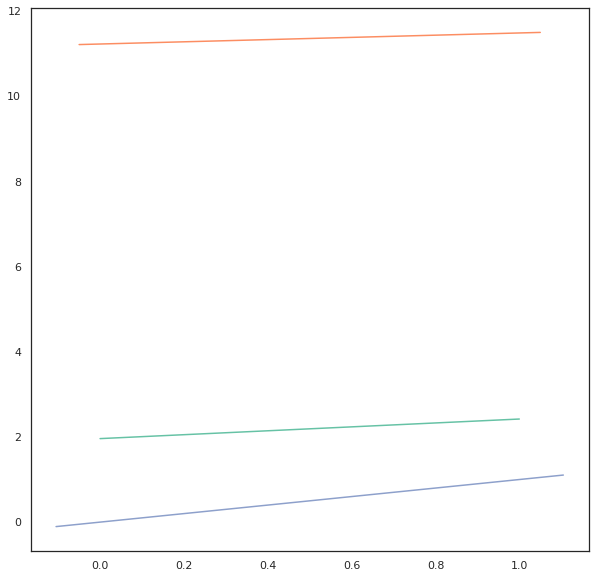

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
abline(0.4597636045784851, 1.9608389325774684, ax)
abline(0.2595561536075119, 11.226312844888445, ax)
abline(1, 0, ax)

In [ ]:
# no qt 25
m, to = train_for_var("rh_98", FEATURES, df=calibration)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

2024-02-04 06:18:59,938 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:30]
2024-02-04 06:23:03,906 DEBUG: Training complete. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:32]
2024-02-04 06:23:06,295 INFO: Training rmse: 6.613862445791358; R^2: 0.6027425883218143 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:37]
2024-02-04 06:23:06,297 INFO: Validation error: 0.4997505610753039 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]


In [ ]:
save_pickle(f"{DATA_PATH}/evaluation/rf/models/model_rh98_advanced_landsat_no_qt_25.pkl", m)
to.export(f"{DATA_PATH}/evaluation/rf/models/to_rh98_advanced_landsat_no_qt_25.pkl")

In [ ]:
get_cf("rh_98", m, FEATURES, df=calibration, tf=test_ds)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

Evaluating Placebo Set 1:
RMSE: 7.948731005517388
R^2: 0.4655632072515913
RMA regression: (0.4525808140714064, 2.186052412105594)


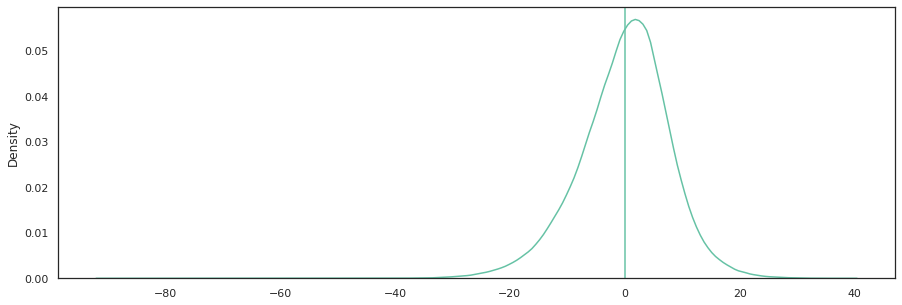

In [ ]:
evaluate_placebo_set("rh_98", test_ds)

# Compare with old data

In [59]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat.pkl")

In [60]:
old = load_pickle(f"{DATA_PATH}/rf/unburned/gedi_match_2020.pkl")

In [61]:
old = old.set_index('shot_number')
old_cali = old[~old.index.isin(test_ds.index)]
old_test = old[old.index.isin(test_ds.index)]

In [62]:
trainer = rf.LandsatTimeSeriesRF([2015, 2016, 2017, 2018, 2019])

In [64]:
m, to = trainer.train("agbd", old_cali, old_test)

2024-02-08 03:40:57,181 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 03:41:01,625 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 03:43:50,978 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 03:43:50,980 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 03:43:52,065 INFO: RMSE: 87.84636226537994; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 03:43:52,082 INFO: R^2: 0.5784616633344272 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 03:43:52,137 INFO: RMA: (0.5215873219242226, -6.722082561143623) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 03:43:52,138 INFO: Validation error: 0.48939915234843057 [i

In [65]:
m, to = trainer.train("agbd", old_cali, old_test, log=True)

2024-02-08 03:44:58,631 DEBUG: Optimizing for log [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]
2024-02-08 03:44:58,977 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 03:45:03,614 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 03:48:00,600 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 03:48:00,602 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 03:48:01,729 INFO: RMSE: 0.5602553574984379; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 03:48:01,746 INFO: R^2: 0.6100530598555942 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 03:48:01,801 INFO: RMA: (0.5501158656943701, -0.47403594570204977) [in log_accuracy at /

In [66]:
m, to = trainer.train("agbd", old_cali, test_ds, log=True)

2024-02-08 03:48:32,730 DEBUG: Optimizing for log [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]
2024-02-08 03:48:33,144 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 03:48:37,887 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 03:51:32,884 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 03:51:32,886 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 03:51:34,072 INFO: RMSE: 0.5602385079337755; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 03:51:34,083 INFO: R^2: 0.6100765146509575 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 03:51:34,123 INFO: RMA: (0.5501858513879797, -0.4747881458039509) [in log_accuracy at /h

## Conclusion:

Using old data we get better accuracy on the training set, but comparable accuracy on the test set. Further more, AGBD predictions are slighly better on the test set than rh 98 predictions.

## RF - 5 years of annual Landsat bands

In [67]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat.pkl")

In [68]:
trainer = rf.LandsatTimeSeriesRF([2010, 2015, 2016, 2017, 2018, 2019])

In [51]:
m, to = trainer.train("NDVI_2020", calibration_ds, test_ds)

2024-02-08 02:12:19,344 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 02:12:23,570 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 02:14:38,490 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 02:14:38,492 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 02:14:39,486 INFO: RMSE: 0.020164877473039133; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 02:14:39,499 INFO: R^2: 0.9768530372967049 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 02:14:39,549 INFO: RMA: (0.9722234510379164, -0.6163325533016941) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 02:14:39,549 INFO: Validation error: 0.9723014411927041

In [52]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 03:33:52,210 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 03:33:56,431 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 03:36:31,855 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 03:36:31,857 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 03:36:32,814 INFO: RMSE: 6.709926393705005; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 03:36:32,828 INFO: R^2: 0.5911186907685108 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 03:36:32,885 INFO: RMA: (0.5294099568119308, -1.2812251509225963) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 03:36:32,885 INFO: Validation error: 0.4951548936407014 [i

In [69]:
m, to = trainer.train("agbd", calibration_ds, test_ds, log=True)

2024-02-08 03:52:46,989 DEBUG: Optimizing for log [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:38]
2024-02-08 03:52:47,375 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 03:52:51,672 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 03:55:21,072 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 03:55:21,075 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 03:55:21,977 INFO: RMSE: 0.588202481672814; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 03:55:21,990 INFO: R^2: 0.5890583559619285 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 03:55:22,045 INFO: RMA: (0.5268213021219676, -0.24715579437782598) [in log_accuracy at /h

## 5 year time series at 2003

In [87]:
year = 2003
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat_{year}.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat_{year}.pkl")

In [88]:
trainer = rf.LandsatTimeSeriesRF(list(range(year - 4, year + 1)))

In [90]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 04:48:12,108 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 04:48:15,199 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 04:50:30,680 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 04:50:30,682 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 04:50:31,545 INFO: RMSE: 6.843180781818417; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 04:50:31,559 INFO: R^2: 0.5747172447676997 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 04:50:31,611 INFO: RMA: (0.5139093410162525, -0.6035519110197693) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 04:50:31,612 INFO: Validation error: 0.4802720234188951 [i

In [97]:
trainer = rf.LandsatTimeSeriesRF(list(range(year - 4, year + 1)))

In [98]:
m, to = trainer.train("rh_98", calibration_ds, test_ds, augment=True)

2024-02-08 05:02:21,461 INFO: Training with features ['SR_B1_1999', 'SR_B2_1999', 'SR_B3_1999', 'SR_B4_1999', 'SR_B5_1999', 'SR_B7_1999', 'NDVI_1999', 'SR_B1_2000', 'SR_B2_2000', 'SR_B3_2000', 'SR_B4_2000', 'SR_B5_2000', 'SR_B7_2000', 'NDVI_2000', 'SR_B1_2001', 'SR_B2_2001', 'SR_B3_2001', 'SR_B4_2001', 'SR_B5_2001', 'SR_B7_2001', 'NDVI_2001', 'SR_B1_2002', 'SR_B2_2002', 'SR_B3_2002', 'SR_B4_2002', 'SR_B5_2002', 'SR_B7_2002', 'NDVI_2002', 'SR_B1_2003', 'SR_B2_2003', 'SR_B3_2003', 'SR_B4_2003', 'SR_B5_2003', 'SR_B7_2003', 'NDVI_2003', 'slope', 'elevation', 'aspect', 'SR_B1_mean', 'SR_B1_std', 'SR_B2_mean', 'SR_B2_std', 'SR_B3_mean', 'SR_B3_std', 'SR_B4_mean', 'SR_B4_std', 'SR_B5_mean', 'SR_B5_std', 'SR_B7_mean', 'SR_B7_std', 'NDVI_mean', 'NDVI_std']. [in train at /home/jk871/fire-regen/src/counterfactuals/rf/rf.py:115]
2024-02-08 05:02:23,033 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 05:02:27,243 DEBUG: Start mode

# 10 year time series at 2003

In [99]:
year = 2003
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_landsat_{year}_10.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_landsat_{year}_10.pkl")

In [100]:
trainer = rf.LandsatTimeSeriesRF(list(range(year - 9, year + 1)))

In [101]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 05:07:59,382 INFO: Training with features ['SR_B1_1994', 'SR_B2_1994', 'SR_B3_1994', 'SR_B4_1994', 'SR_B5_1994', 'SR_B7_1994', 'NDVI_1994', 'SR_B1_1995', 'SR_B2_1995', 'SR_B3_1995', 'SR_B4_1995', 'SR_B5_1995', 'SR_B7_1995', 'NDVI_1995', 'SR_B1_1996', 'SR_B2_1996', 'SR_B3_1996', 'SR_B4_1996', 'SR_B5_1996', 'SR_B7_1996', 'NDVI_1996', 'SR_B1_1997', 'SR_B2_1997', 'SR_B3_1997', 'SR_B4_1997', 'SR_B5_1997', 'SR_B7_1997', 'NDVI_1997', 'SR_B1_1998', 'SR_B2_1998', 'SR_B3_1998', 'SR_B4_1998', 'SR_B5_1998', 'SR_B7_1998', 'NDVI_1998', 'SR_B1_1999', 'SR_B2_1999', 'SR_B3_1999', 'SR_B4_1999', 'SR_B5_1999', 'SR_B7_1999', 'NDVI_1999', 'SR_B1_2000', 'SR_B2_2000', 'SR_B3_2000', 'SR_B4_2000', 'SR_B5_2000', 'SR_B7_2000', 'NDVI_2000', 'SR_B1_2001', 'SR_B2_2001', 'SR_B3_2001', 'SR_B4_2001', 'SR_B5_2001', 'SR_B7_2001', 'NDVI_2001', 'SR_B1_2002', 'SR_B2_2002', 'SR_B3_2002', 'SR_B4_2002', 'SR_B5_2002', 'SR_B7_2002', 'NDVI_2002', 'SR_B1_2003', 'SR_B2_2003', 'SR_B3_2003', 'SR_B4_2003', 'SR_B5_2003', 'SR

In [102]:
m.predict(to.valid.xs)

array([21.09889223, 16.99805774, 18.07178357, ..., 17.87525884,
       31.12574025, 30.65260813])

In [104]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    sns.lineplot(x=x_vals, y=y_vals, ax=ax)

[0.0, 100.0, 0.0, 100.0]


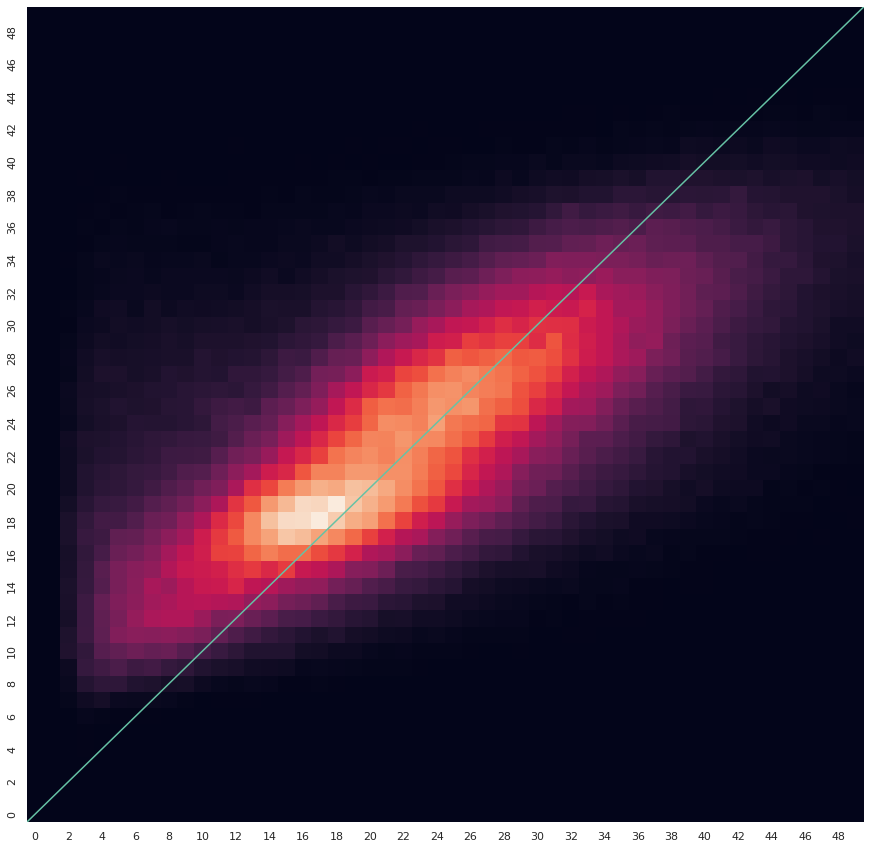

In [105]:
heatmap, xedges, yedges = np.histogram2d(to.valid.y, m.predict(to.valid.xs), bins=100, range=[[0, 100], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print(extent)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(heatmap.T, cbar=False)
ax.set_xlim((0, 50))
ax.set_ylim((0, 50))
abline(1, 0, ax)

In [107]:
fi = rf.rf_feat_importance(m, to.train.xs)
fi[:20]

,cols,imp
141,SR_B2_2002,0.250370
144,SR_B5_2002,0.113829
142,SR_B3_2002,0.051964
145,SR_B7_2002,0.042100
147,SR_B1_2003,0.032941
156,aspect,0.032708
159,SR_B2_mean,0.028448
155,elevation,0.025813
167,SR_B7_mean,0.025125
161,SR_B3_mean,0.020035


## RF for NDVI - simple

First, let's just train RF for NDVI, using placebo set 1 as a training / testing set.

In [55]:
test_ds = load_pickle(f"{INPUT_PATH}/set1/placebo_aug_ndvis.pkl")
calibration_ds = load_pickle(f"{INPUT_PATH}/set1/calibration_aug_ndvis.pkl")

In [56]:
trainer = rf.NDVITimeSeriesRF([2015, 2016, 2017, 2018, 2019])

In [38]:
m, to = trainer.train("ndvi_2020", calibration_ds, test_ds)

2024-02-08 00:50:56,010 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 00:50:57,112 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 00:51:44,127 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 00:51:44,128 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 00:51:44,852 INFO: RMSE: 0.022149621570483197; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 00:51:44,867 INFO: R^2: 0.9720722815070288 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 00:51:44,920 INFO: RMA: (0.9688093039606569, -0.6118596887594352) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 00:51:44,920 INFO: Validation error: 0.9679780337544387

In [58]:
m, to = trainer.train("rh_98", calibration_ds, test_ds)

2024-02-08 03:39:13,644 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 03:39:14,710 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 03:40:04,267 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 03:40:04,269 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 03:40:04,968 INFO: RMSE: 7.541286338958252; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 03:40:04,981 INFO: R^2: 0.48352107058454386 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 03:40:05,035 INFO: RMA: (0.4365624173974378, 2.7800792443363402) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 03:40:05,036 INFO: Validation error: 0.39681838189490304 [

In [41]:
m, to = trainer.train("ndvi_2022", calibration_ds, test_ds)

2024-02-08 01:35:23,548 INFO: PREP PREP PREP-- [in prep_data_for_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:76]
2024-02-08 01:35:24,652 DEBUG: Start model training. [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:45]
2024-02-08 01:36:17,594 DEBUG: Training complete.
 [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:47]
2024-02-08 01:36:17,596 INFO: Training Accuracy: [in train_rf at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:49]
2024-02-08 01:36:18,301 INFO: RMSE: 0.03651950791082439; [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:65]
2024-02-08 01:36:18,311 INFO: R^2: 0.9238598715064845 [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:66]
2024-02-08 01:36:18,346 INFO: RMA: (0.9160100438334482, -0.5338496591781148) [in log_accuracy at /home/jk871/fire-regen/src/counterfactuals/rf/train.py:67]
2024-02-08 01:36:18,347 INFO: Validation error: 0.9124516563228416 

## Conclusion:

Performance of predicting future NDVI from past NDVIs, decreases in accuracy over time. Not much difference with augmented features. Maybe a bit better with NDVI from 2010, maaaaybe